# Improvements for stacked GLCM models (with final train + save)

In [1]:
import sys
import os
from git_root import git_root

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D, Dense, LeakyReLU
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

sys.path.append(git_root("utils"))
from utils import load_config, load_params

sys.path.append(git_root("models"))
from validation_utils import plot_history
from affine_scalar_layer import AffineScalar

sys.path.append(git_root("training"))
from fetch_data import fetch_data_local
from fetch_data import to_numpy_arrays, prepare_tf_dataset

In [2]:
print(tf.__version__)

2.0.0


In [3]:
config, params = load_config(), load_params()

In [4]:
angles = params["GLCM"]["mel_map"]["angles_in_deg"]

In [5]:
train = {
    "spectrogram": {0: []},
    "mel_map": {
        angle: [] for angle in angles
    }
}
test = {
    "spectrogram": {0: []},
    "mel_map": {
        angle: [] for angle in angles
    }
}

## Create stacks

In [6]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        train[map_type][angle] = fetch_data_local(
            map_type=map_type, train=True, angle=angle
        )
        test[map_type][angle] = fetch_data_local(
            map_type=map_type, train=False, angle=angle
        )

Map: spectrogram, angle: 0
Fetching: data_spectrogram_angle_0_train.json
Fetching: data_spectrogram_angle_0_test.json
Map: mel_map, angle: 0
Fetching: data_mel_map_angle_0_train.json
Fetching: data_mel_map_angle_0_test.json
Map: mel_map, angle: 45
Fetching: data_mel_map_angle_45_train.json
Fetching: data_mel_map_angle_45_test.json
Map: mel_map, angle: 90
Fetching: data_mel_map_angle_90_train.json
Fetching: data_mel_map_angle_90_test.json
Map: mel_map, angle: 135
Fetching: data_mel_map_angle_135_train.json
Fetching: data_mel_map_angle_135_test.json


In [7]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        print("train")
        print(train[map_type][angle].shape)
        print("test")
        print(test[map_type][angle].shape)

Map: spectrogram, angle: 0
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 0
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 45
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 90
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 135
train
(12600, 4)
test
(1400, 4)


In [8]:
for map_type in train:
    for angle in train[map_type]:
        train[map_type][angle] = to_numpy_arrays(
            train[map_type][angle]
        )
        test[map_type][angle] = to_numpy_arrays(
            test[map_type][angle]
        )

In [9]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        print("train")
        print(len(train[map_type][angle][0]))
        print(len(train[map_type][angle][1]))
        print("test")
        print(len(test[map_type][angle][0]))
        print(len(test[map_type][angle][1]))

Map: spectrogram, angle: 0
train
12600
12600
test
1400
1400
Map: mel_map, angle: 0
train
12600
12600
test
1400
1400
Map: mel_map, angle: 45
train
12600
12600
test
1400
1400
Map: mel_map, angle: 90
train
12600
12600
test
1400
1400
Map: mel_map, angle: 135
train
12600
12600
test
1400
1400


Now we also need a stacked dataset for the combined i-GLCM model:

In [10]:
stacked_train = (
    [
        np.stack([
            np.squeeze(train["mel_map"][angle][0][i]) for angle in angles
        ], -1) for i in range(len(train["mel_map"][0][0]))
    ],
    train["mel_map"][0][1]
)
stacked_test = (
    [
        np.stack([
            np.squeeze(test["mel_map"][angle][0][i]) for angle in angles
        ], -1) for i in range(len(test["mel_map"][0][0]))
    ],
    test["mel_map"][0][1]
)

In [11]:
print(stacked_train[0][0].shape)

(15, 15, 4)


In [12]:
stacked_train = prepare_tf_dataset(
    stacked_train[0], stacked_train[1]
)
stacked_test = prepare_tf_dataset(
    stacked_test[0], stacked_test[1]
)

In [13]:
print(f"Map: stacked mel_maps")
tr_sample_batch, tr_label_batch = next(iter(stacked_train))
te_sample_batch, te_label_batch = next(iter(stacked_test))
print("train")
print(tr_sample_batch.shape, tr_label_batch.shape)
print("test")
print(te_sample_batch.shape, te_label_batch.shape)

Map: stacked mel_maps
train
(32, 15, 15, 4) (32,)
test
(32, 15, 15, 4) (32,)


## Normalize input

In [14]:
def normalize(glcm, label):
    glcm = glcm / tf.reduce_max(glcm)
    return glcm, label

In [15]:
normalized_stacked_train = stacked_train.map(normalize)
normalized_stacked_test = stacked_test.map(normalize)

In [16]:
print(f"Map: normalized stacked mel_maps")
tr_sample_batch, tr_label_batch = next(iter(normalized_stacked_train))
print(tr_sample_batch.shape, tr_label_batch.shape)
print(tr_sample_batch[0, :, :, 0])

Map: normalized stacked mel_maps
(32, 15, 15, 4) (32,)
tf.Tensor(
[[0.27848101 0.12025316 0.06329114 0.06962025 0.02531646 0.03164557
  0.02531646 0.00632911 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.17088608 0.11392405 0.         0.05063291 0.05696203 0.03164557
  0.00632911 0.00632911 0.01265823 0.00632911 0.         0.
  0.         0.         0.        ]
 [0.07594937 0.06962025 0.08860759 0.         0.02531646 0.0443038
  0.01265823 0.00632911 0.00632911 0.         0.01898734 0.
  0.         0.         0.        ]
 [0.07594937 0.0443038  0.05696203 0.05063291 0.03164557 0.03797468
  0.00632911 0.01898734 0.00632911 0.00632911 0.01265823 0.
  0.         0.         0.        ]
 [0.01265823 0.0443038  0.03164557 0.05063291 0.03164557 0.06962025
  0.01898734 0.01265823 0.00632911 0.00632911 0.         0.
  0.         0.         0.        ]
 [0.03164557 0.03164557 0.0443038  0.07594937 0.06962025 0.12025316
  0.10759494 0.06962025 0.05696203 0.05063291 0

In [17]:
def setup_model_vanilla(M=4, activation="tanh"):
    input_dim = params["quantization"]["n_levels"] - 1
    n_genres = len(config["genres"])

    model = Sequential()
    model.add(
        Conv2D(
            12, 
            (6, 6), 
            activation=activation, 
            input_shape=(input_dim, input_dim, M),
            name="conv1"
        )
    )
    model.add(AveragePooling2D((2, 2), name="pooling1"))
    model.add(AffineScalar(name="affine"))
    model.add(Conv2D(6, (3,3), activation=activation, name="conv2"))
    model.add(GlobalAveragePooling2D(name="pooling2"))
    model.add(Dense(n_genres, activation="softmax", name="dense"))

    return model

In [18]:
#We load the model
vanilla = setup_model_vanilla(M=4)
vanilla.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 10, 10, 12)        1740      
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 5, 5, 12)          0         
_________________________________________________________________
affine (AffineScalar)        (None, 5, 5, 12)          2         
_________________________________________________________________
conv2 (Conv2D)               (None, 3, 3, 6)           654       
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                70        
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
______________________________________________________

In [19]:
vanilla.compile(
    optimizer=Adam(learning_rate=0.0001, beta_2=.998),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_vanilla = vanilla.fit(
    normalized_stacked_train, 
    epochs=500, 
    validation_data=normalized_stacked_test
)

Epoch 1/500
394/394 [==============================] - 4s 10ms/step - loss: 2.3086 - accuracy: 0.1061 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3075 - accuracy: 0.0170 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 3/500
394/394 [==============================] - 2s 6ms/step - loss: 2.3077 - accuracy: 0.0241 - val_loss: 2.3023 - val_accuracy: 0.1171
Epoch 4/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3079 - accuracy: 0.0983 - val_loss: 2.3020 - val_accuracy: 0.1000
Epoch 5/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3068 - accuracy: 0.1041 - val_loss: 2.3016 - val_accuracy: 0.1000
Epoch 6/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3059 - accuracy: 0.0967 - val_loss: 2.3013 - val_accuracy: 0.1000
Epoch 7/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3064 - accuracy: 0.0767 - val_loss: 2.3008 - val_accurac

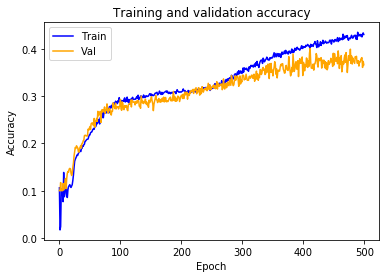

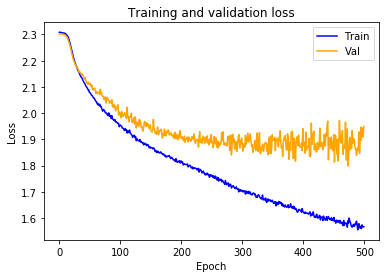

In [21]:
plot_history(history_vanilla)

In [22]:
print(f"Final validation accuracy is: {history_vanilla.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.366


## Replacing tanh by ReLU

In [23]:
def setup_model_leaky(M=4):
    input_dim = params["quantization"]["n_levels"] - 1
    n_genres = len(config["genres"])

    model = Sequential()
    model.add(
        Conv2D(
            12, 
            (6, 6),
            input_shape=(input_dim, input_dim, M),
            name="conv1"
        )
    )
    model.add(LeakyReLU())
    model.add(AveragePooling2D((2, 2), name="pooling1"))
    model.add(AffineScalar(name="affine"))
    model.add(Conv2D(6, (3,3), name="conv2"))
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling2D(name="pooling2"))
    model.add(Dense(n_genres, activation="softmax", name="dense"))

    return model

In [24]:
#We load the model
relu = setup_model_leaky(M=4)
relu.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 10, 10, 12)        1740      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10, 10, 12)        0         
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 5, 5, 12)          0         
_________________________________________________________________
affine (AffineScalar)        (None, 5, 5, 12)          2         
_________________________________________________________________
conv2 (Conv2D)               (None, 3, 3, 6)           654       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3, 3, 6)           0         
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 6)                

In [25]:
relu.compile(
    optimizer=Adam(learning_rate=0.0001, beta_2=.998),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_relu = relu.fit(
    normalized_stacked_train, 
    epochs=500, 
    validation_data=normalized_stacked_test
)

Epoch 1/500
394/394 [==============================] - 3s 9ms/step - loss: 2.3071 - accuracy: 0.0946 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3080 - accuracy: 0.0021 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 3/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3066 - accuracy: 0.1179 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3060 - accuracy: 0.0509 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3052 - accuracy: 0.0710 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3050 - accuracy: 0.0377 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 7/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3083 - accuracy: 0.0053 - val_loss: 2.3026 - val_accuracy

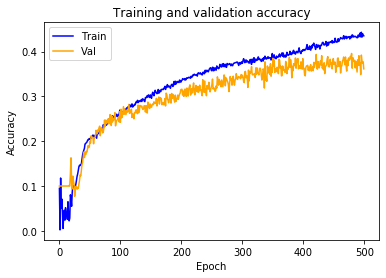

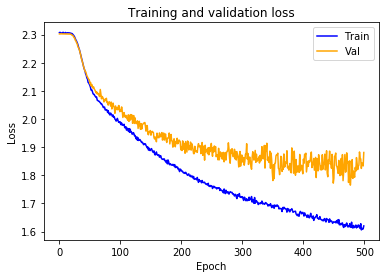

In [27]:
plot_history(history_relu)

In [28]:
print(f"Final validation accuracy is: {history_relu.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.361


## Smaller convolutional filters

Smaller filters, more of them and removal of the Affine Scalar layer

In [29]:
def setup_model_smaller_filters(M=4):
    input_dim = params["quantization"]["n_levels"] - 1
    n_genres = len(config["genres"])

    model = Sequential()
    model.add(
        Conv2D(
            24, 
            (3, 3),
            input_shape=(input_dim, input_dim, M),
            name="conv1"
        )
    )
    model.add(LeakyReLU())
    model.add(AveragePooling2D((2, 2), name="pooling1"))
    model.add(Conv2D(12, (2, 2), name="conv2"))
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling2D(name="pooling2"))
    model.add(Dense(n_genres, activation="softmax", name="dense"))

    return model

In [30]:
#We load the model
smaller = setup_model_smaller_filters(M=4)
smaller.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 13, 13, 24)        888       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 13, 13, 24)        0         
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 6, 6, 24)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 5, 12)          1164      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5, 5, 12)          0         
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 10)               

In [31]:
smaller.compile(
    optimizer=Adam(learning_rate=0.0001, beta_2=.998),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
history_smaller = smaller.fit(
    normalized_stacked_train, 
    epochs=1000, 
    validation_data=normalized_stacked_test
)

Epoch 1/1000
394/394 [==============================] - 3s 7ms/step - loss: 2.3146 - accuracy: 0.1826 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/1000
394/394 [==============================] - 2s 4ms/step - loss: 2.3096 - accuracy: 0.1814 - val_loss: 2.3028 - val_accuracy: 0.0993
Epoch 3/1000
394/394 [==============================] - 2s 4ms/step - loss: 2.3082 - accuracy: 0.1579 - val_loss: 2.3023 - val_accuracy: 0.1000
Epoch 4/1000
394/394 [==============================] - 2s 4ms/step - loss: 2.3076 - accuracy: 0.1267 - val_loss: 2.3025 - val_accuracy: 0.0979
Epoch 5/1000
394/394 [==============================] - 2s 4ms/step - loss: 2.3073 - accuracy: 0.1034 - val_loss: 2.3020 - val_accuracy: 0.1179
Epoch 6/1000
394/394 [==============================] - 2s 4ms/step - loss: 2.3070 - accuracy: 0.0869 - val_loss: 2.3019 - val_accuracy: 0.1014
Epoch 7/1000
394/394 [==============================] - 2s 4ms/step - loss: 2.3064 - accuracy: 0.0755 - val_loss: 2.3021 - val_a

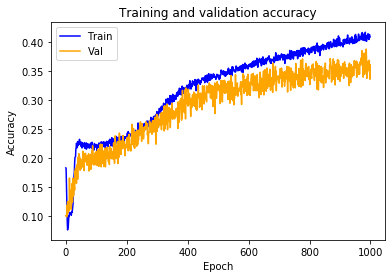

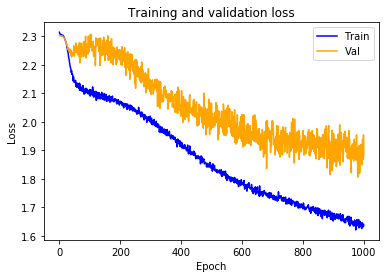

In [33]:
plot_history(history_smaller)

In [34]:
print(f"Final validation accuracy is: {history_smaller.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.361


## More convolutional layers

In [35]:
def setup_model_deeper(M=4):
    input_dim = params["quantization"]["n_levels"] - 1
    n_genres = len(config["genres"])

    model = Sequential()
    model.add(
        Conv2D(
            24, 
            (3, 3),
            input_shape=(input_dim, input_dim, M),
            name="conv1"
        )
    )
    model.add(LeakyReLU())
    model.add(AveragePooling2D((2, 2), name="pooling1"))
    model.add(Conv2D(12, (2, 2), name="conv2"))
    model.add(LeakyReLU())
    model.add(Conv2D(12, (2, 2), name="conv3"))
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling2D(name="pooling2"))
    model.add(Dense(n_genres, activation="softmax", name="dense"))

    return model

In [36]:
#We load the model
deeper = setup_model_deeper(M=4)
deeper.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 13, 13, 24)        888       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 13, 13, 24)        0         
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 6, 6, 24)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 5, 12)          1164      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 5, 5, 12)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 4, 4, 12)          588       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 12)         

In [37]:
deeper.compile(
    optimizer=Adam(learning_rate=0.0001, epsilon=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
history_deeper = deeper.fit(
    normalized_stacked_train, 
    epochs=1000, 
    validation_data=normalized_stacked_test
)

Epoch 1/1000
394/394 [==============================] - 4s 9ms/step - loss: 2.3161 - accuracy: 0.0340 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3095 - accuracy: 0.0525 - val_loss: 2.3025 - val_accuracy: 0.0950
Epoch 3/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3089 - accuracy: 0.0419 - val_loss: 2.3024 - val_accuracy: 0.0986
Epoch 4/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3079 - accuracy: 0.0457 - val_loss: 2.3022 - val_accuracy: 0.0836
Epoch 5/1000
394/394 [==============================] - 2s 6ms/step - loss: 2.3074 - accuracy: 0.0611 - val_loss: 2.3018 - val_accuracy: 0.0957
Epoch 6/1000
394/394 [==============================] - 2s 6ms/step - loss: 2.3071 - accuracy: 0.0706 - val_loss: 2.3019 - val_accuracy: 0.1114
Epoch 7/1000
394/394 [==============================] - 2s 6ms/step - loss: 2.3074 - accuracy: 0.0691 - val_loss: 2.3015 - val_a

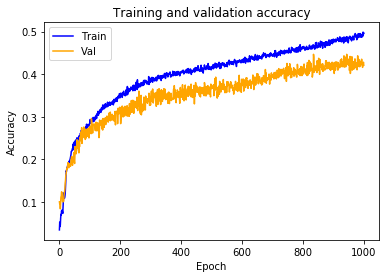

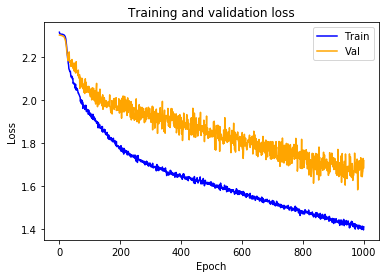

In [39]:
plot_history(history_deeper)

In [40]:
print(f"Final validation accuracy is: {history_deeper.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.421


## Add dropout

In [41]:
def setup_model_dropout(M=4):
    input_dim = params["quantization"]["n_levels"] - 1
    n_genres = len(config["genres"])

    model = Sequential()
    model.add(
        Conv2D(
            24, 
            (3, 3),
            input_shape=(input_dim, input_dim, M),
            name="conv1"
        )
    )
    model.add(LeakyReLU())
    model.add(AveragePooling2D((2, 2), name="pooling1"))
    model.add(Conv2D(12, (2, 2), name="conv2"))
    model.add(LeakyReLU())
    model.add(Conv2D(12, (2, 2), name="conv3"))
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling2D(name="pooling2"))
    model.add(Dropout(0.3))
    model.add(Dense(n_genres, activation="softmax", name="dense"))

    return model

In [42]:
#We load the model
dropout = setup_model_dropout(M=4)
dropout.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 13, 13, 24)        888       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 13, 13, 24)        0         
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 6, 6, 24)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 5, 12)          1164      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 5, 5, 12)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 4, 4, 12)          588       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4, 4, 12)         

In [43]:
dropout.compile(
    optimizer=Adam(learning_rate=0.0001, beta_2=.998),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
history_dropout = dropout.fit(
    normalized_stacked_train, 
    epochs=1000, 
    validation_data=normalized_stacked_test
)

Epoch 1/1000
394/394 [==============================] - 3s 8ms/step - loss: 2.3066 - accuracy: 0.0534 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3145 - accuracy: 0.0488 - val_loss: 2.3019 - val_accuracy: 0.1107
Epoch 3/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3079 - accuracy: 0.0510 - val_loss: 2.3024 - val_accuracy: 0.1007
Epoch 4/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3067 - accuracy: 0.0589 - val_loss: 2.3022 - val_accuracy: 0.1029
Epoch 5/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3075 - accuracy: 0.0407 - val_loss: 2.3022 - val_accuracy: 0.1000
Epoch 6/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3070 - accuracy: 0.0570 - val_loss: 2.3019 - val_accuracy: 0.1050
Epoch 7/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3071 - accuracy: 0.0573 - val_loss: 2.3015 - val_a

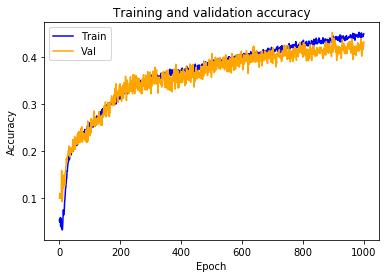

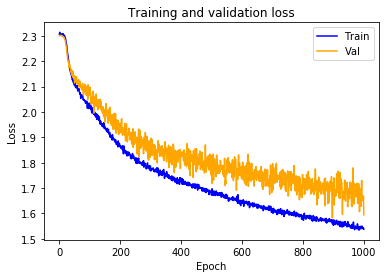

In [45]:
plot_history(history_dropout)

In [46]:
print(f"Final validation accuracy is: {history_dropout.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.433


## Max-pooling instead of average pooling

In [47]:
def setup_model_max(M=4):
    input_dim = params["quantization"]["n_levels"] - 1
    n_genres = len(config["genres"])

    model = Sequential()
    model.add(
        Conv2D(
            24, 
            (3, 3),
            input_shape=(input_dim, input_dim, M),
            name="conv1"
        )
    )
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2, 2), name="pooling1"))
    model.add(Conv2D(12, (2, 2), name="conv2"))
    model.add(LeakyReLU())
    model.add(Conv2D(12, (2, 2), name="conv3"))
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling2D(name="pooling2"))
    model.add(Dropout(0.3))
    model.add(Dense(n_genres, activation="softmax", name="dense"))

    return model

In [48]:
#We load the model
max_ = setup_model_max(M=4)
max_.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 13, 13, 24)        888       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 13, 13, 24)        0         
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 6, 6, 24)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 5, 12)          1164      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 5, 5, 12)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 4, 4, 12)          588       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4, 4, 12)         

In [49]:
max_.compile(
    optimizer=Adam(learning_rate=0.0001, beta_2=.998),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [50]:
history_max = max_.fit(
    normalized_stacked_train, 
    epochs=1000, 
    validation_data=normalized_stacked_test
)

Epoch 1/1000
394/394 [==============================] - 3s 8ms/step - loss: 2.3180 - accuracy: 0.0966 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3100 - accuracy: 0.1032 - val_loss: 2.3019 - val_accuracy: 0.1964
Epoch 3/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3085 - accuracy: 0.1162 - val_loss: 2.3017 - val_accuracy: 0.1536
Epoch 4/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3078 - accuracy: 0.1390 - val_loss: 2.3014 - val_accuracy: 0.1514
Epoch 5/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3078 - accuracy: 0.1483 - val_loss: 2.3004 - val_accuracy: 0.1543
Epoch 6/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3071 - accuracy: 0.1492 - val_loss: 2.2996 - val_accuracy: 0.1443
Epoch 7/1000
394/394 [==============================] - 2s 5ms/step - loss: 2.3065 - accuracy: 0.1249 - val_loss: 2.2985 - val_a

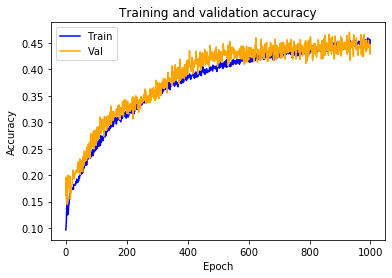

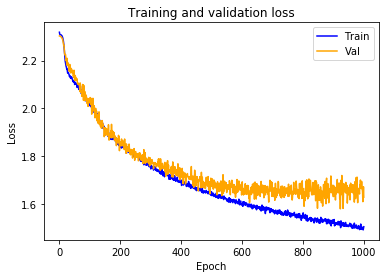

In [51]:
plot_history(history_max)

In [52]:
print(f"Final validation accuracy is: {history_max.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.446


In [53]:
def setup_model_dense(M=4):
    input_dim = params["quantization"]["n_levels"] - 1
    n_genres = len(config["genres"])

    model = Sequential()
    model.add(
        Conv2D(
            24, 
            (3, 3),
            input_shape=(input_dim, input_dim, M),
            name="conv1"
        )
    )
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2, 2), name="pooling1"))
    model.add(Conv2D(12, (2, 2), name="conv2"))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(32, name="dense1"))
    model.add(LeakyReLU())
    model.add(Dense(n_genres, activation="softmax", name="dense2"))

    return model

In [54]:
#We load the model
dense = setup_model_dense(M=4)
dense.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 13, 13, 24)        888       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 13, 13, 24)        0         
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 6, 6, 24)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 5, 5, 12)          1164      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 5, 5, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)              

In [55]:
dense.compile(
    optimizer=Adam(learning_rate=0.0001, beta_2=.998),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
history_dense = dense.fit(
    normalized_stacked_train, 
    epochs=300, 
    validation_data=normalized_stacked_test
)

Epoch 1/300
394/394 [==============================] - 3s 8ms/step - loss: 2.3092 - accuracy: 0.1173 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/300
394/394 [==============================] - 2s 5ms/step - loss: 2.3174 - accuracy: 0.0837 - val_loss: 2.2939 - val_accuracy: 0.1007
Epoch 3/300
394/394 [==============================] - 2s 6ms/step - loss: 2.2797 - accuracy: 0.1083 - val_loss: 2.3059 - val_accuracy: 0.1136
Epoch 4/300
394/394 [==============================] - 2s 6ms/step - loss: 2.3128 - accuracy: 0.0974 - val_loss: 2.2849 - val_accuracy: 0.1693
Epoch 5/300
394/394 [==============================] - 2s 6ms/step - loss: 2.2823 - accuracy: 0.0974 - val_loss: 2.2611 - val_accuracy: 0.1307
Epoch 6/300
394/394 [==============================] - 2s 6ms/step - loss: 2.2851 - accuracy: 0.0727 - val_loss: 2.2455 - val_accuracy: 0.1436
Epoch 7/300
394/394 [==============================] - 2s 5ms/step - loss: 2.2305 - accuracy: 0.0860 - val_loss: 2.2267 - val_accuracy

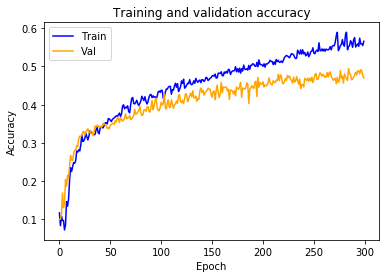

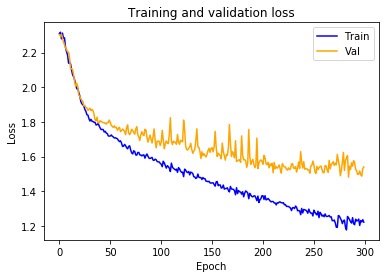

In [57]:
plot_history(history_dense)

In [58]:
print(f"Final validation accuracy is: {history_dense.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.470


## Save final model

In [59]:
file_path = git_root("models", "saved_models", "stacked_final.h5")
dense.save(file_path)